Chargement des librairies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

Vérifions la GPU

In [2]:
# Vérification de l'utilisation du GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Utilisation de : {device}')

Utilisation de : cuda


Préparons les données

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.GaussianBlur(5),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_data = torchvision.datasets.ImageFolder(root='../dataset/Training/', transform=transform_train)
test_data = torchvision.datasets.ImageFolder(root='../dataset/Testing/', transform=transform_test)

In [5]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

# Visualisation des données

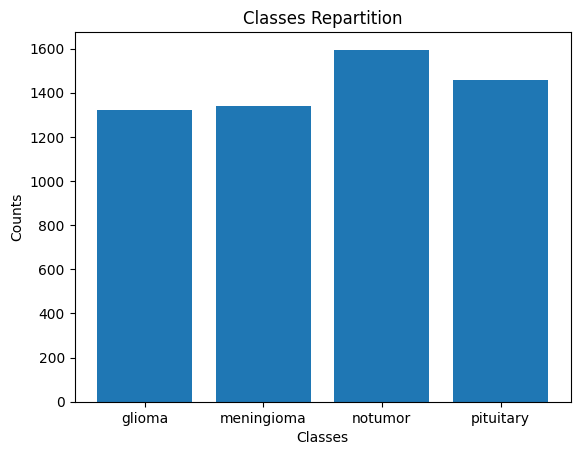

In [6]:
# show classes repartition in the dataset
import matplotlib.pyplot as plt
import numpy as np

classes = train_data.classes
class_counts = np.bincount(train_data.targets)
plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Classes Repartition')
plt.show()

Définissons le CNN

In [6]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(DeepCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.lqyer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(28800, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layers(out)
        return out

In [7]:
model = DeepCNN().to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001)

Entrainements

In [9]:
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    
    #Validation
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_epoch_loss = val_running_loss / len(test_loader)
    val_epoch_accuracy = 100 * correct / total
        
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')

Epoch [1/30], Loss: 1.3968, Accuracy: 68.08%
Validation Loss: 0.6673, Validation Accuracy: 72.39%
Epoch [2/30], Loss: 0.5532, Accuracy: 78.34%
Validation Loss: 0.5537, Validation Accuracy: 78.26%
Epoch [3/30], Loss: 0.4891, Accuracy: 80.55%
Validation Loss: 0.4215, Validation Accuracy: 83.22%
Epoch [4/30], Loss: 0.4539, Accuracy: 82.49%
Validation Loss: 0.4219, Validation Accuracy: 84.52%
Epoch [5/30], Loss: 0.4096, Accuracy: 84.52%
Validation Loss: 0.4652, Validation Accuracy: 82.99%
Epoch [6/30], Loss: 0.3715, Accuracy: 85.05%
Validation Loss: 0.4290, Validation Accuracy: 82.68%
Epoch [7/30], Loss: 0.3454, Accuracy: 87.13%
Validation Loss: 0.4297, Validation Accuracy: 84.29%
Epoch [8/30], Loss: 0.3163, Accuracy: 87.90%
Validation Loss: 0.3548, Validation Accuracy: 86.50%
Epoch [9/30], Loss: 0.2861, Accuracy: 89.51%
Validation Loss: 0.3296, Validation Accuracy: 88.48%
Epoch [10/30], Loss: 0.2782, Accuracy: 89.81%
Validation Loss: 0.3292, Validation Accuracy: 88.41%
Epoch [11/30], Loss

Affichage de courbes 

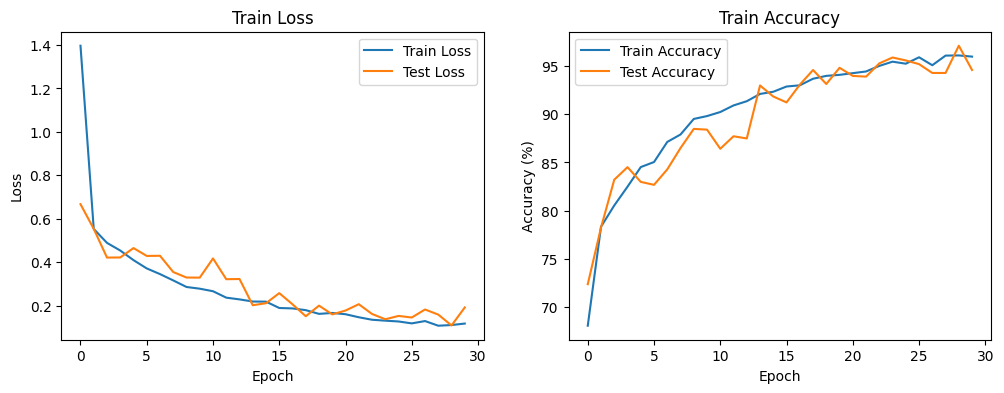

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train Accuracy')

plt.show()

Métriques

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
all_preds = []
all_labels = []
all_scores = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        scores = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(scores.cpu().numpy())


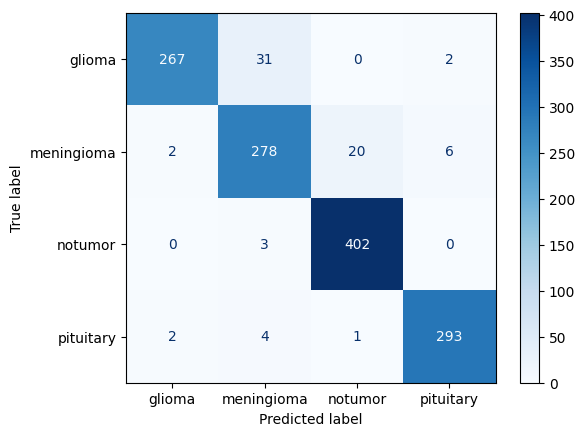

In [17]:
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

y_true = all_labels
y_pred = all_preds

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
roc_auc = roc_auc_score(y_true, all_scores, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.9458428680396643
Precision: 0.9471908061702348
Recall: 0.9419389978213507
F1-Score: 0.9437870415958348
ROC-AUC: 0.9926658967116757


Sauvegarde du modèle

In [14]:
torch.save(model.state_dict(), 'cnn_model1.pth')